In [1]:
# Setup
import time
import os
import csv
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm

from keras.preprocessing.image import load_img

import pyjet.data as pyjet
from data import FullCarDataset
import rle
from models import u_net_full_img as model_func
from models import MODEL_FILE

# File paths
TRAIN_DIR = "../input/train/"
METADATA_PATH = "../input/metadata.csv"
SAVE_DIR = "../input/train_pred_masks/"
MODEL_FILE = MODEL_FILE.format(model_func.__name__)

# Script stuff
ORIG_IMGSIZE = (1918, 1280)
IMGSIZE = (1280, 1920)
BATCH_SIZE = 4
SEED = 1234
np.random.seed(SEED)

# Make the dataset
car_dataset = FullCarDataset(base_dir=TRAIN_DIR, metadata_path=METADATA_PATH,
                             img_size=IMGSIZE, resize=False)
print("Complete Dataset: ", len(car_dataset), " samples")

car_gen = pyjet.DatasetGenerator(car_dataset, batch_size=BATCH_SIZE, shuffle=True, seed=np.random.randint(10000))
print("Prediction Steps: ", car_gen.steps_per_epoch, " steps")

Using TensorFlow backend.


PyJet is using CUDA.
Complete Dataset:  5088  samples
Prediction Steps:  1272  steps


In [2]:
# Create the model
model = model_func(car_dataset.img_size, train=False)
model.load_weights(MODEL_FILE)
batch_img, batch_long_ids = next(car_gen)
batch_preds = model.predict_on_batch(batch_img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 1920, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1280, 1920, 2)     56        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280, 1920, 2)     8         
_________________________________________________________________
activation_1 (Activation)    (None, 1280, 1920, 2)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1280, 1920, 2)     38        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280, 1920, 2)     8         
_________________________________________________________________
activation_2 (Activation)    (None, 1280, 1920, 2)     0         
__________

In [3]:
print(batch_preds.shape)
def tile_arrays(arrays, grid_shape):
    grid = np.empty((grid_shape[0] * arrays.shape[1], grid_shape[1] * arrays.shape[2]))
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            grid[i*arrays.shape[1]:(i+1)*arrays.shape[1], j*arrays.shape[2]:(j+1)*arrays.shape[2]] = arrays[i*grid_shape[1]+j]
    return grid

(4, 1280, 1920)


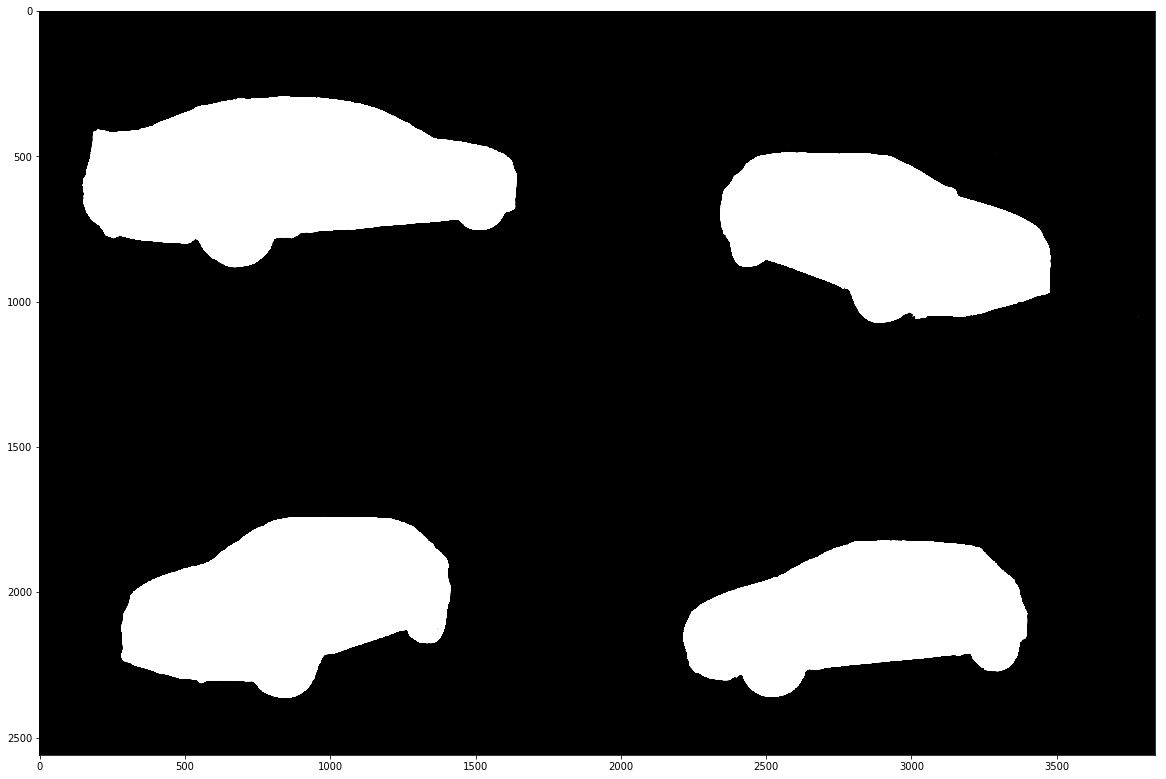

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(tile_arrays(batch_preds, (2, 2)), cmap='gray')
plt.show()

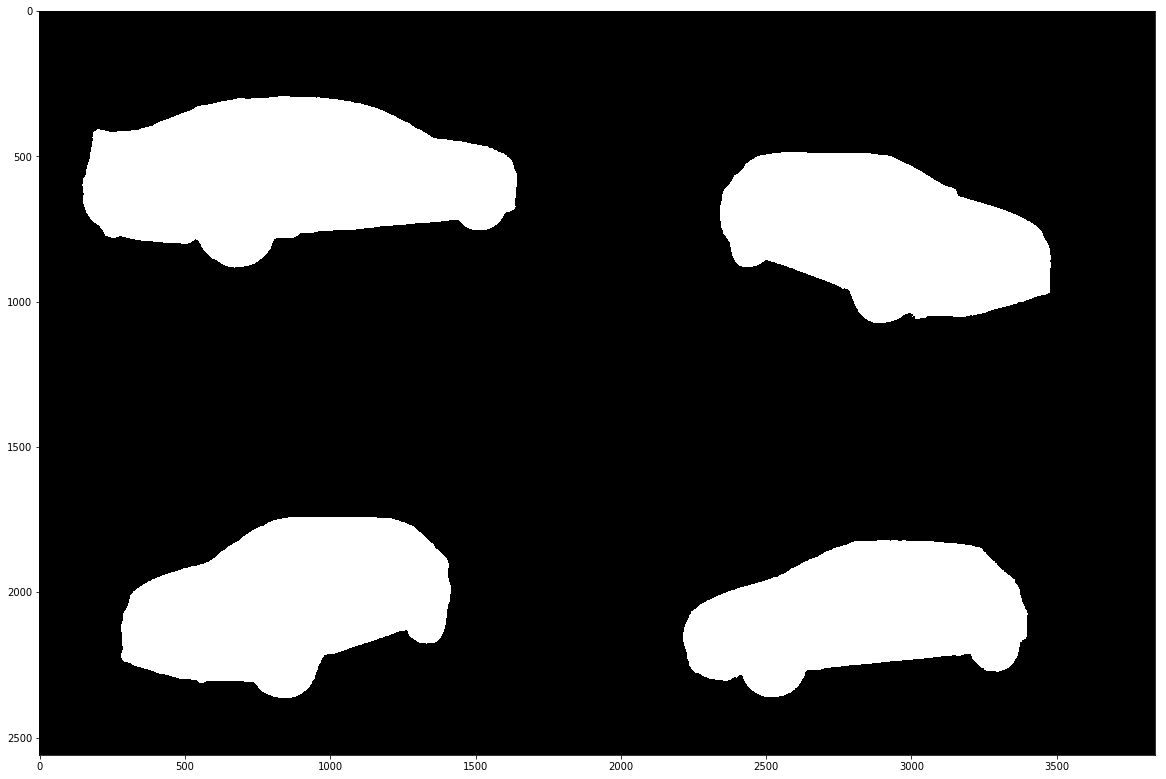

In [5]:
tmp = np.rint(batch_preds)
plt.figure(figsize=(20,20))
plt.imshow(tile_arrays(tmp, (2, 2)), cmap='gray')
plt.show()

In [6]:
import scipy.ndimage as ndi

tmp2 = np.zeros(tmp.shape)
for i in range(tmp.shape[0]):
#     ndi.binary_dilation(tmp[i], output=tmp2[i], iterations=2)
    ndi.binary_closing(tmp[i], output=tmp2[i], iterations=30)
plt.figure(figsize=(60,30))
plt.imshow(tile_arrays(tmp2, (8, 4)), cmap='gray')
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4